The dataset can be downloaded from here and it consists of 18000 grayscale images (18000x150x150
or 18000x75x75) contained in ‘images.npy’. The labels for each sample are represented by two integers
(18000x2, ‘labels.npy’ file), that correspond to the hour and minute displayed by the clock. You can see
that each image is rendered from a different angle and rotation and they might contain light reflections from
within the scene making this a non-trivial problem. For your experiments, we suggest splitting your data
into 80/10/10% splits for training/validation and test sets respectively. Remember to shuffle your dataset
as the sample files are ordered. We suggest using the smaller dataset for your initial tests and runs (75x75
images) and then reporting your results on the larger (150x150) datase

## GPU CHECK

In [4]:
import tensorflow  as tf
print(tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"TensorFlow detected {len(gpus)} GPU(s):")
    for gpu in gpus:
        print(f"  - {gpu.name}")
else:
    print("TensorFlow did NOT detect any GPUs. It will use the CPU.")


2025-11-05 14:55:00.428006: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-05 14:55:00.461805: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-05 14:55:01.276164: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.20.0
TensorFlow detected 1 GPU(s):
  - /physical_device:GPU:0


#### import needed packages

In [5]:

# from tensorflow import keras
import os
# import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
import keras


#### load data

In [6]:
pixel_size = 150
data_folder = f"A1_data_{pixel_size}"
images_path = os.path.join(data_folder, "images.npy")
images = np.load(images_path)
labels_path = os.path.join(data_folder, "labels.npy")
labels = np.load(labels_path)


(a) Classification - treat this as a n-class classification problem. We suggest starting out with a
smaller number of categories e.g. grouping all the samples that are between [3 : 00 −3 : 30] into
a single category (results in 24 categories in total), and trying to train a CNN model. Once you
have found a working architecture, increase the number of categories by using smaller intervals
for grouping samples to increase the ’common sense accuracy’. Can you train a network using
all 720 different labels? What problems does such a label representation have?

## Task a: classification
We will start with deviding labels into 24 categories, one for each 30 minute

In [7]:

print(labels)
def get_cat_labels(labels):
    new_labels = []
    for label in labels:
        label = label[0]* 2 + int(label[1] >= 30)
        new_labels.append(label)
    return np.array(new_labels)
labels = get_cat_labels(labels)
print(labels)


[[ 0  0]
 [ 0  0]
 [ 0  0]
 ...
 [11 59]
 [11 59]
 [11 59]]
[ 0  0  0 ... 23 23 23]


We then split the data into training, validation, and test sets. The sklearn train_test_split method shuffles the data by default

In [8]:
X_train_full, X_test,y_train_full, y_test = train_test_split(
    images, labels, test_size=0.1, random_state=35
)
X_train, X_valid,y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=1/9, random_state=35
) # 1/9 x 0.9 = 0.1.


we define a common sense loss. This will calculate how far of the prediction was

In [9]:
def make_common_sense_loss(num_classes=24.0):
    def common_sense_loss(y_true, y_pred):
        y_pred_class = tf.argmax(y_pred, axis=1)
        y_true_float = tf.cast(tf.squeeze(y_true), dtype=tf.float32)
        y_pred_float = tf.cast(y_pred_class, dtype=tf.float32)
        diff = tf.abs(y_true_float - y_pred_float)
        cyclical_diff = tf.minimum(diff, num_classes- diff)
        return tf.reduce_mean(cyclical_diff * 720 /num_classes)
    return common_sense_loss

Our model for 24 class classification. We use a scheduler to lower the learning rate when we plateau



In [10]:
def create_model(num_classes=24):
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,          # halve the learning rate if there is no improvement
        patience=3,          # Wait 2 epochs with no improvement before reducing
        min_lr=1e-6          # Set a minimum learning rate at 1e-6
    )
    early_stopper = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,          # Wait 6 epochs for improvement before stopping
        restore_best_weights=True  # Automatically restore the weights from the best epoch
    )
    model= keras.models.Sequential([
        keras.Input(shape=(pixel_size, pixel_size, 1)),
        # Block 1
        keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2)),
        # keras.layers.Dropout(0.2),
        # Block 2
        keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2),
        # keras.layers.Dropout(0.2),
        # Block 3
        keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2),
        # keras.layers.Dropout(0.2),
        # Block 4
        keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2),
        # keras.layers.Dropout(0.2), #dropout not needed, bacuase of max pooling

        # #block 5
        # keras.layers.Conv2D(512, (3,3), activation="relu", padding="same"),
        # keras.layers.BatchNormalization(),
        # keras.layers.Conv2D(512, (3,3), activation="relu", padding="same"),
        # keras.layers.BatchNormalization(),
        # keras.layers.MaxPooling2D(2),
        # # keras.layers.Dropout(0.2),

        keras.layers.Flatten(),
        keras.layers.Dense(128, activation="leaky_relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation="leaky_relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(int(num_classes), activation="softmax")
    ])
    cse = make_common_sense_loss(num_classes=num_classes)
    model.compile(loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[cse,"Accuracy"
            #   tf.keras.metrics.Precision(), tf.keras.metrics.Recall()
            ],
    )
    return model, lr_scheduler, early_stopper
model, lr_scheduler, early_stopper = create_model()


I0000 00:00:1762350904.229658   42404 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6119 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [11]:
model.save("time_prediction_model_class.keras")

In [12]:
# #make plot for model architecture
# keras.utils.plot_model(
#     model,
#     to_file="model_plot_compact.png",
#     show_shapes=True,
#     show_layer_names=False,
#     show_layer_activations=False
# )

In [13]:
# model.fit(
#     X_train, y_train,
#     epochs=60,
#     validation_data=(X_valid, y_valid),
#     callbacks=[lr_scheduler, early_stopper]
#     )
# #evaluate the model on the test set
# test_loss,test_csl, test_acc = model.evaluate(X_test, y_test)
# print('Test accuracy:', test_acc)
# #base:0.8420000076293945
# #leaky: 0.8525000214576721
# #leaky + L2regularization: 0.8472999930381775
# #leaky + batch normalization: 0.8978000283241272
# #0.9711111187934875
# #0.36 at 25
# # metrics=["accuracy"])

We now make a class for every 10 minutes

In [14]:
labels = np.load(labels_path)

def get_cat_labels_10(labels):
    new_labels = []
    dct = {}
    for label in labels:
        old = label
        label = label[0]* 6 + int((label[1])/10)
        new_labels.append(label)
        dct[str(old)] = label
    print(dct)
    return np.array(new_labels)
labels = get_cat_labels_10(labels)
# labels = keras.utils.to_categorical(labels, num_classes=72)
print(labels)


{'[0 0]': np.int64(0), '[0 1]': np.int64(0), '[0 2]': np.int64(0), '[0 3]': np.int64(0), '[0 4]': np.int64(0), '[0 5]': np.int64(0), '[0 6]': np.int64(0), '[0 7]': np.int64(0), '[0 8]': np.int64(0), '[0 9]': np.int64(0), '[ 0 10]': np.int64(1), '[ 0 11]': np.int64(1), '[ 0 12]': np.int64(1), '[ 0 13]': np.int64(1), '[ 0 14]': np.int64(1), '[ 0 15]': np.int64(1), '[ 0 16]': np.int64(1), '[ 0 17]': np.int64(1), '[ 0 18]': np.int64(1), '[ 0 19]': np.int64(1), '[ 0 20]': np.int64(2), '[ 0 21]': np.int64(2), '[ 0 22]': np.int64(2), '[ 0 23]': np.int64(2), '[ 0 24]': np.int64(2), '[ 0 25]': np.int64(2), '[ 0 26]': np.int64(2), '[ 0 27]': np.int64(2), '[ 0 28]': np.int64(2), '[ 0 29]': np.int64(2), '[ 0 30]': np.int64(3), '[ 0 31]': np.int64(3), '[ 0 32]': np.int64(3), '[ 0 33]': np.int64(3), '[ 0 34]': np.int64(3), '[ 0 35]': np.int64(3), '[ 0 36]': np.int64(3), '[ 0 37]': np.int64(3), '[ 0 38]': np.int64(3), '[ 0 39]': np.int64(3), '[ 0 40]': np.int64(4), '[ 0 41]': np.int64(4), '[ 0 42]': 

In [15]:
X_train_full, X_test,y_train_full, y_test = train_test_split(
    images, labels, test_size=0.1, random_state=35
)
X_train, X_valid,y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=1/9, random_state=35
) # 1/9 x 0.9 = 0.1. train test split shuffles by default
print(y_valid)


[48 33 45 ... 41  4  0]


In [16]:
model, lr_scheduler, early_stopper = create_model(num_classes=72.0)

In [17]:
# print(X_valid.shape)
# model.fit(
#     X_train, y_train,
#     epochs=60,
#     validation_data=(X_valid, y_valid),
#     callbacks=[lr_scheduler, early_stopper]
#     )
# #evaluate the model on the test set
# test_loss,test_csl, test_acc = model.evaluate(X_test, y_test)
# print('Test accuracy:', test_acc)
# #base:0.8420000076293945
# #leaky: 0.8525000214576721
# #leaky + L2regularization: 0.8472999930381775
# #leaky + batch normalization: 0.8978000283241272

# #0.9194444417953491
# # metrics=["accuracy"])

In [18]:
labels = np.load(labels_path)
def get_cat_labels_min(labels):
    new_labels = []
    dct = {}
    for label in labels:
        old = label
        label = label[0]* 60 + int((label[1]))
        new_labels.append(label)
        dct[str(old)] = label
    print(dct)
    return np.array(new_labels)
labels = get_cat_labels_min(labels)


{'[0 0]': np.int64(0), '[0 1]': np.int64(1), '[0 2]': np.int64(2), '[0 3]': np.int64(3), '[0 4]': np.int64(4), '[0 5]': np.int64(5), '[0 6]': np.int64(6), '[0 7]': np.int64(7), '[0 8]': np.int64(8), '[0 9]': np.int64(9), '[ 0 10]': np.int64(10), '[ 0 11]': np.int64(11), '[ 0 12]': np.int64(12), '[ 0 13]': np.int64(13), '[ 0 14]': np.int64(14), '[ 0 15]': np.int64(15), '[ 0 16]': np.int64(16), '[ 0 17]': np.int64(17), '[ 0 18]': np.int64(18), '[ 0 19]': np.int64(19), '[ 0 20]': np.int64(20), '[ 0 21]': np.int64(21), '[ 0 22]': np.int64(22), '[ 0 23]': np.int64(23), '[ 0 24]': np.int64(24), '[ 0 25]': np.int64(25), '[ 0 26]': np.int64(26), '[ 0 27]': np.int64(27), '[ 0 28]': np.int64(28), '[ 0 29]': np.int64(29), '[ 0 30]': np.int64(30), '[ 0 31]': np.int64(31), '[ 0 32]': np.int64(32), '[ 0 33]': np.int64(33), '[ 0 34]': np.int64(34), '[ 0 35]': np.int64(35), '[ 0 36]': np.int64(36), '[ 0 37]': np.int64(37), '[ 0 38]': np.int64(38), '[ 0 39]': np.int64(39), '[ 0 40]': np.int64(40), '[ 0

In [19]:
X_train_full, X_test,y_train_full, y_test = train_test_split(
    images, labels, test_size=0.1, random_state=35
)
X_train, X_valid,y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=1/9, random_state=35
) # 1/9 x 0.9 = 0.1. train test split shuffles by default
# get the number of instances in each class
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Class distribution in y_train:")
for class_label, count in class_counts.items():
    if count < 17 or count > 24:
        print(f"Class {class_label}: {count} instances")

Class distribution in y_train:
Class 1: 12 instances
Class 27: 15 instances
Class 40: 25 instances
Class 64: 14 instances
Class 66: 16 instances
Class 109: 16 instances
Class 156: 16 instances
Class 161: 16 instances
Class 162: 15 instances
Class 297: 16 instances
Class 312: 16 instances
Class 316: 15 instances
Class 320: 16 instances
Class 367: 16 instances
Class 370: 16 instances
Class 376: 15 instances
Class 377: 16 instances
Class 383: 15 instances
Class 384: 15 instances
Class 412: 25 instances
Class 420: 16 instances
Class 473: 25 instances
Class 475: 25 instances
Class 493: 16 instances
Class 514: 16 instances
Class 576: 16 instances
Class 596: 16 instances
Class 600: 15 instances
Class 609: 16 instances
Class 620: 16 instances
Class 633: 16 instances
Class 647: 16 instances
Class 649: 16 instances
Class 717: 14 instances


In [20]:
model, lr_scheduler, early_stopper = create_model(num_classes=720)

In [21]:
# model.fit(
#     X_train, y_train,
#     epochs=60,
#     validation_data=(X_valid, y_valid),
#     callbacks=[lr_scheduler, early_stopper]
#     )
# # evaluate the model on the test set
# test_loss,test_csl, test_acc = model.evaluate(X_test, y_test)

# print('Test accuracy:', test_acc)
# (print(tf.__version__))
# #0.9194444417953491
# # metrics=["accuracy"])

In [22]:
#feature prep for dual head

labels = np.load(labels_path)


In [23]:
X_train_full, X_test,y_train_full, y_test = train_test_split(
    images, labels, test_size=0.1, random_state=35
)
X_train, X_valid,y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=1/9, random_state=35
) # 1/9 x 0.9 = 0.1. train test split shuffles by default

In [24]:
y_train_hours = y_train[:, 0]
y_train_minutes = y_train[:, 1]
y_valid_hours = y_valid[:, 0]
y_valid_minutes = y_valid[:, 1]
y_test_hours = y_test[:, 0]
y_test_minutes = y_test[:, 1]

#one-hot encoding the labels
y_train_hours_enc = keras.utils.to_categorical(y_train_hours, num_classes=12)
y_train_minutes_enc = y_train_minutes
y_valid_hours_enc = keras.utils.to_categorical(y_valid_hours, num_classes=12)
y_valid_minutes_enc = y_valid_minutes
y_test_hours_enc = keras.utils.to_categorical(y_test_hours, num_classes=12)
y_test_minutes_enc = y_test_minutes
y_train_formatted = {
    "hour_output": y_train_hours_enc,
    "minute_output": y_train_minutes_enc
}

y_valid_formatted = {
    "hour_output": y_valid_hours_enc,
    "minute_output": y_valid_minutes_enc
}
y_train_formatted = {
    "hour_output": y_train_hours_enc,
    "minute_output": y_train_minutes_enc
}

y_valid_formatted = {
    "hour_output": y_valid_hours_enc,
    "minute_output": y_valid_minutes_enc
}


In [25]:
def custom_mse(y_true, y_pred):
    """
    Deal with cyclical nature of time for minutes
    0-59 minutes, so difference between 0 and 59 is 1 minute
    """
    y_true = tf.cast(y_true, dtype=tf.float32)
    diff = tf.abs(y_true - y_pred)
    cyclical_diff = tf.minimum(diff, 60.0 - diff)
    return tf.reduce_mean(tf.square(cyclical_diff))

In [26]:

inputs = keras.Input(shape=(pixel_size, pixel_size, 1), name="input_image")
x = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D((2,2))(x)
x = keras.layers.Dropout(0.15)(x)

x = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(2)(x)
x = keras.layers.Dropout(0.15)(x)

x = keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(2)(x)
x = keras.layers.Dropout(0.15)(x)

x = keras.layers.Conv2D(256, (3,3), activation="relu", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(2)(x)
x = keras.layers.MaxPooling2D(2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation="leaky_relu", kernel_regularizer=keras.regularizers.l2(0.001))(x)
shared_features = keras.layers.Dropout(0.5)(x)
hour_branch = keras.layers.Dense(64, activation="leaky_relu", kernel_regularizer=keras.regularizers.l2(0.001))(shared_features)
hour_branch = keras.layers.Dropout(0.5)(hour_branch)
hour_output = keras.layers.Dense(12, activation="softmax", name="hour_output")(hour_branch)
minute_branch = keras.layers.Dense(128, activation="leaky_relu",
                                   kernel_regularizer=keras.regularizers.l2(0.001))(shared_features)
minute_branch = keras.layers.Dropout(0.5)(minute_branch)
minute_output = keras.layers.Dense(1, activation="linear", name="minute_output")(minute_branch)

model = keras.Model(inputs=inputs, outputs=[hour_output, minute_output])
minute_loss_weight = 0.002 #mse is a lot higher than crossentropy. minutes also influence final time less.
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        "hour_output": "categorical_crossentropy",
        "minute_output": "mean_squared_error"
        # custom_mse
    },
    loss_weights={
        "hour_output": 1,
        "minute_output": minute_loss_weight
    },
    metrics={
        "hour_output": "accuracy",
        "minute_output": 'mean_absolute_error'
    }
)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 150, 150,  │        320 │ input_image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │        128 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 75, 75,    │          0 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 75, 75,    │     18,496 │ dropout_6[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 75, 75,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 37, 37,    │          0 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 37, 37,    │     73,856 │ dropout_7[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │        512 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 37, 37,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │        512 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 18, 18,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 18, 18,    │          0 │ max_pooling2d_14

 Total params: 2,772,109 (10.57 MB)

 Trainable params: 2,770,765 (10.57 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [27]:
import keras.backend as K

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.10,          # halce the learning rate if no improvement
    patience=5,          # Wait 4 epochs with no improvement before reducing
    min_lr=1e-7        # Set a minimum learning rate at 1e-6
)
early_stopper = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,          # Wait 8 epochs for improvement before stopping
    restore_best_weights=True  # Automatically restore the model weights from the best epoch
)
# model.fit(
#     X_train, y_train_formatted,
#     epochs=80,
#     validation_data=(X_valid, y_valid_formatted),
#     callbacks=[lr_scheduler, early_stopper]
#     )
# K.clear_session()

In [28]:
def common_sense_loss(y_true, y_pred):
        y_true_hour = np.argmax(y_true["hour_output"], axis=1)
        y_true_minute = np.array(y_true["minute_output"], dtype=float)
        y_pred_hour = np.argmax(y_pred[0], axis=1)
        y_pred_minute = y_pred[1].squeeze()
        y_true_total_minutes = y_true_hour * 60 + y_true_minute
        y_pred_total_minutes = y_pred_hour * 60 + y_pred_minute
        diff = y_true_total_minutes - y_pred_total_minutes
        abs_diff = tf.abs(diff)


        cyclical_error = tf.minimum(abs_diff, 720.0 - abs_diff)

        return cyclical_error

In [29]:
# y_test_minutes_enc = np.array(y_test_minutes, dtype=float)
# model.evaluate(X_test, {
#     "hour_output": y_test_hours_enc,
#     "minute_output": y_test_minutes_enc
# })
# y_test_formatted = {
#     "hour_output": y_test_hours_enc,
#     "minute_output": y_test_minutes_enc
# }
# y_pred_list = model.predict(X_test)

# np.mean((common_sense_loss(y_test_formatted, y_pred_list)))
# #7.683456
# #8.94813338364164
# (8.887957806802458)


regression esque

In [30]:
#label prep for regression model
labels = np.load(labels_path)
labels_in_minutes = []
for label in labels:
    total_minutes = label[0] * 60 + label[1]
    labels_in_minutes.append(total_minutes)
labels_in_minutes = np.array(labels_in_minutes)
X_train_full, X_test,y_train_full, y_test = train_test_split(
    images, labels_in_minutes, test_size=0.1, random_state=35
)
X_train, X_valid,y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=1/9, random_state=35
) # 1/9 x 0.9 = 0.1. train test split shuffles by default


In [31]:
def create_regmodel():
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,          # halve the learning rate if there is no improvement
        patience=3,          # Wait 2 epochs with no improvement before reducing
        min_lr=1e-6          # Set a minimum learning rate at 1e-6
    )
    early_stopper = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,          # Wait 6 epochs for improvement before stopping
        restore_best_weights=True  # Automatically restore the weights from the best epoch
    )
    model= keras.models.Sequential([
        keras.Input(shape=(pixel_size, pixel_size, 1)),
        # Block 1
        keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Dropout(0.2),
        # Block 2
        keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2),
        keras.layers.Dropout(0.2),
        # Block 3
        keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2),
        keras.layers.Dropout(0.2),
        # Block 4
        keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2),
        keras.layers.Dropout(0.2),


        keras.layers.Flatten(),
        keras.layers.Dense(128, activation="leaky_relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation="leaky_relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation="linear"),
    ])
    # cse = common_sense_loss
    model.compile(loss='MeanSquaredError',
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['mean_absolute_error',
            #   common_sense_loss
            #   tf.keras.metrics.Precision(), tf.keras.metrics.Recall()
            ],
    )
    return model, lr_scheduler, early_stopper
model, lr_scheduler, early_stopper = create_regmodel()

In [32]:
# model.fit(
#     X_train, y_train,
#     epochs=60,
#     validation_data=(X_valid, y_valid),
#     callbacks=[lr_scheduler, early_stopper]
#     )

In [33]:
def common_sense_loss(y_true, y_pred):
        y_true = tf.cast(tf.squeeze(y_true), dtype=tf.float32)
        y_pred = tf.cast(tf.squeeze(y_pred), dtype=tf.float32)
        diff = y_true - y_pred
        abs_diff = tf.abs(diff)

        cyclical_error = tf.minimum(abs_diff, 720.0 - abs_diff)
        return float(tf.reduce_mean(cyclical_error))

In [34]:
# model.evaluate(X_test, y_test)
# y_pred = model.predict(X_test)
# print(y_pred.shape, y_test.shape)
# print(common_sense_loss(y_test, y_pred.squeeze()))

In [35]:

labels = np.load(labels_path)
#Separate hours and minutes
hours = labels[:, 0]
minutes = labels[:, 1]

#Transform hours into sine and cosine components
hour_sin = np.sin(2 * np.pi * hours / 12.0)
hour_cos = np.cos(2 * np.pi * hours / 12.0)
y_hour = np.stack([hour_sin, hour_cos], axis=1)
# Do the same for minutes
minute_sin = np.sin(2 * np.pi * minutes / 60.0)
minute_cos = np.cos(2 * np.pi * minutes / 60.0)
y_minute = np.stack([minute_sin, minute_cos], axis=1)

# Split into train_full (90%) and test (10%)
X_train_full, X_test, \
y_hour_train_full, y_hour_test, \
y_minute_train_full, y_minute_test = train_test_split(
    images, y_hour, y_minute, test_size=0.1, random_state=35
)

X_train, X_valid, \
y_hour_train, y_hour_valid, \
y_minute_train, y_minute_valid = train_test_split(
    X_train_full, y_hour_train_full, y_minute_train_full,
    test_size=1/9, random_state=35
) # 1/9 x 0.9 = 0.1. train test split shuffles by default


In [ ]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomRotation(factor=(12 / 360)),
        keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1)
    ],
    name="data_augmentation_pipeline"
)
inputs = keras.Input(shape=(pixel_size, pixel_size, 1), name="input_images")
x = data_augmentation(inputs)
x = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D((2,2))(x)
x = keras.layers.Dropout(0.15)(x)

x = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(2)(x)
x = keras.layers.Dropout(0.15)(x)

x = keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(2)(x)
x = keras.layers.Dropout(0.15)(x)


x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation="leaky_relu", kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = keras.layers.Dropout(0.3)(x)
hour_branch = keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(x)
hour_branch = keras.layers.Dropout(0.3)(hour_branch)
hour_output = keras.layers.Dense(2, activation="tanh", name="hour_output")(hour_branch)
minute_branch = keras.layers.Dense(128, activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)
                                   )(x)
minute_branch = keras.layers.Dropout(0.3)(minute_branch)
minute_output = keras.layers.Dense(2, activation="linear", name="minute_output")(minute_branch)

model = keras.Model(inputs=inputs, outputs=[hour_output, minute_output])
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss={
        "hour_output": "mean_squared_error",
        "minute_output": "mean_squared_error"
    },
    metrics={
        "hour_output": "mean_absolute_error",
        "minute_output": 'mean_absolute_error'
    }
)


In [41]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,          # halve the learning rate if there is no improvement
        patience=3,          # Wait 3 epochs with no improvement before reducing
        min_lr=1e-6          # Set a minimum learning rate at 1e-6
    )
early_stopper = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,          # Wait 6 epochs for improvement before stopping
        restore_best_weights=True  # Automatically restore the weights from the best epoch
    )
csv_logger = keras.callbacks.CSVLogger(
    filename="time_dual_head_training_log_data_gen.csv",
    separator=",",
    append=True  #makes sure results are appended to same file if training stops and is resumed
)

model.fit(
    X_train, {"hour_output": y_hour_train, "minute_output": y_minute_train},
    epochs=70,
    validation_data=(X_valid, {"hour_output": y_hour_valid, "minute_output": y_minute_valid}),
    callbacks=[lr_scheduler, early_stopper, csv_logger]
    )


Epoch 1/70


2025-11-05 15:01:17.754749: I external/local_xla/xla/service/service.cc:163] XLA service 0x7edb84004a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-05 15:01:17.754771: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-11-05 15:01:17.803109: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-05 15:01:18.081725: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-11-05 15:01:18.308030: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-05 15:01:18.

  3/450 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - hour_output_loss: 1.3343 - hour_output_mean_absolute_error: 0.9392 - loss: 1353.9677 - minute_output_loss: 1352.1364 - minute_output_mean_absolute_error: 19.4488

I0000 00:00:1762351287.204218   43072 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - hour_output_loss: 1.3705 - hour_output_mean_absolute_error: 0.9490 - loss: 155.1747 - minute_output_loss: 153.1628 - minute_output_mean_absolute_error: 4.6255

2025-11-05 15:01:48.514579: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_368', 20 bytes spill stores, 20 bytes spill loads



450/450 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - hour_output_loss: 1.3734 - hour_output_mean_absolute_error: 0.9494 - loss: 37.0205 - minute_output_loss: 35.0005 - minute_output_mean_absolute_error: 1.9428 - val_hour_output_loss: 1.3688 - val_hour_output_mean_absolute_error: 0.9394 - val_loss: 2.3549 - val_minute_output_loss: 0.5080 - val_minute_output_mean_absolute_error: 0.6361 - learning_rate: 0.0010
Epoch 2/70
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - hour_output_loss: 1.2166 - hour_output_mean_absolute_error: 0.8690 - loss: 2.0606 - minute_output_loss: 0.5034 - minute_output_mean_absolute_error: 0.6256 - val_hour_output_loss: 0.8761 - val_hour_output_mean_absolute_error: 0.7226 - val_loss: 1.5684 - val_minute_output_loss: 0.4324 - val_minute_output_mean_absolute_error: 0.5814 - learning_rate: 0.0010
Epoch 3/70
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - hour_output_loss: 0.4879 - hour_output_mean_absolute_error: 0.5923 - loss: 1.0620 - minute_output_loss: 0.4219 - minute_output_me

In [42]:
def sin_cos_to_time(sin_cos,period):
    sin_component = sin_cos[:, 0]
    cos_component = sin_cos[:, 1]
    angles = np.arctan2(sin_component, cos_component)
    angle_positive = np.mod(angles, 2 * np.pi)
    time_values = (angle_positive / (2 * np.pi)) * period
    return np.round(time_values).astype(int)


In [ ]:
#save the trained model
# model.save("time_prediction_model_dual_head_4.keras") 2.633
model.save("time_prediction_model_dual_head_preproc.keras") #2.578333333333333
# model = keras.models.load_model("time_prediction_model_dual_head.keras")


In [44]:
y_pred = model.predict(X_test)
pred_hours = sin_cos_to_time(y_pred[0], 12)
pred_minutes = sin_cos_to_time(y_pred[1], 60)
total_pred_minutes = pred_hours * 60 + pred_minutes

true_hours = sin_cos_to_time(y_hour_test, 12)
true_minutes = sin_cos_to_time(y_minute_test, 60)
total_true_minutes = true_hours * 60 + true_minutes
error_in_minutes = total_true_minutes - total_pred_minutes
abs_error = np.abs(error_in_minutes)
cyclical_error = np.minimum(abs_error, 720 - abs_error)

print("Mean absolute error in minutes:", np.mean(cyclical_error))
#print accuracy
correct_predictions = np.sum(cyclical_error == 0)
total_predictions = len(cyclical_error)
accuracy = correct_predictions / total_predictions
print("Accuracy (exact time predictions):", accuracy)
#accuracy within 5 minutes
correct_within_5 = np.sum(cyclical_error <= 5)
accuracy_within_5 = correct_within_5 / total_predictions
print("Accuracy (predictions within 5 minutes):", accuracy_within_5)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Mean absolute error in minutes: 2.578333333333333
Accuracy (exact time predictions): 0.5411111111111111
Accuracy (predictions within 5 minutes): 0.965


In [ ]:
#sanity check
for i in range(1000):
    if cyclical_error[i] > 1:
        print(f"Predicted time: {pred_hours[i]:02d}:{pred_minutes[i]:02d} | True time: {true_hours[i]:02d}:{true_minutes[i]:02d} | Error in minutes: {cyclical_error[i]}")

Predicted time: 07:44 | True time: 07:46 | Error in minutes: 2
Predicted time: 02:56 | True time: 02:54 | Error in minutes: 2
Predicted time: 11:01 | True time: 00:02 | Error in minutes: 61
Predicted time: 08:39 | True time: 09:37 | Error in minutes: 58
Predicted time: 01:57 | True time: 00:57 | Error in minutes: 60
Predicted time: 05:55 | True time: 06:54 | Error in minutes: 59
Predicted time: 04:57 | True time: 03:57 | Error in minutes: 60
Predicted time: 11:00 | True time: 00:01 | Error in minutes: 61
Predicted time: 07:25 | True time: 07:22 | Error in minutes: 3
Predicted time: 04:15 | True time: 04:13 | Error in minutes: 2
Predicted time: 04:09 | True time: 04:07 | Error in minutes: 2
Predicted time: 01:58 | True time: 00:58 | Error in minutes: 60
Predicted time: 04:21 | True time: 04:19 | Error in minutes: 2
Predicted time: 08:38 | True time: 08:36 | Error in minutes: 2
Predicted time: 01:59 | True time: 00:59 | Error in minutes: 60
Predicted time: 06:30 | True time: 06:28 | Erro

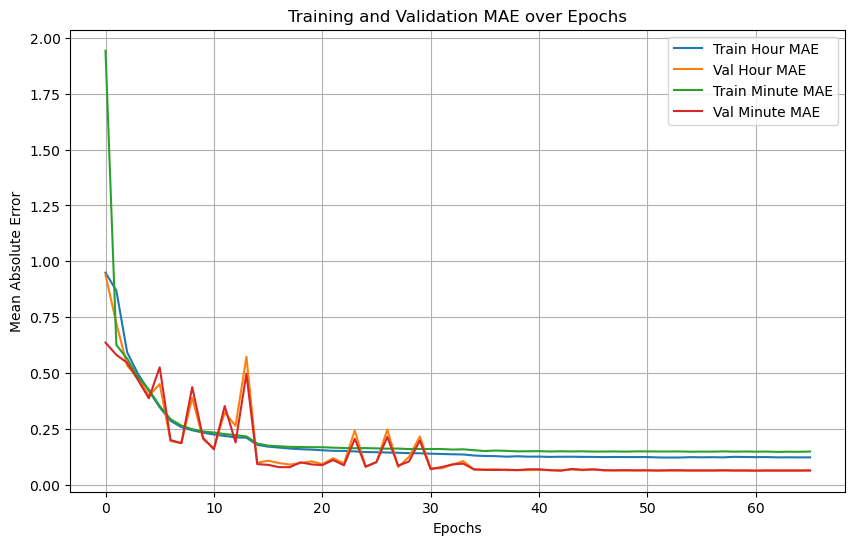

In [ ]:
#plot mae over epochs
import pandas as pd
import matplotlib.pyplot as plt


log_data = pd.read_csv("time_dual_head_training_log_data_gen.csv")
plt.figure(figsize=(10, 6))
plt.plot(log_data['epoch'], log_data['hour_output_mean_absolute_error'], label='Train Hour MAE')
plt.plot(log_data['epoch'], log_data['val_hour_output_mean_absolute_error'], label='Val Hour MAE')
plt.plot(log_data['epoch'], log_data['minute_output_mean_absolute_error'], label='Train Minute MAE')
plt.plot(log_data['epoch'], log_data['val_minute_output_mean_absolute_error'], label='Val Minute MAE')

plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE over Epochs')
plt.legend()
plt.grid()
plt.savefig("dual_head_mae_plot2.png")